In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from copy import deepcopy
from collections import deque

from extrapolation import *
from experiments import difference_matrix

In [2]:
torch.cuda.is_available()

True

In [3]:
train_ds = datasets.MNIST("../MNIST", download=True, train=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST("../MNIST", download=True, train=False, transform=transforms.ToTensor())
valid_size = int(0.2 * len(train_ds))
train_ds, valid_ds = data.random_split(train_ds, [len(train_ds) - valid_size, valid_size])

train_loader = data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_loader = data.DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(4*4*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(-1),
)
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=10, bias=True)
  (14): LogSoftmax(dim=-1)
)

In [5]:
val_loss_fn = nn.NLLLoss(reduction="sum")

def params_to_vector(parameters):
    param_vectors = []
    for param in parameters:
        param_vectors.append(param.data.flatten().cpu())
    return torch.hstack(param_vectors)

def params_from_vector(parameters, x):
    idx = 0
    for param in parameters:
        n = param.data.numel()
        param.data[:] = x[idx:idx+n].view(param.data.shape)
        idx += n

def validation(model, loader):
    ok = 0
    loss_sum = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            out = model(x)
            loss_sum += val_loss_fn(out, y)
            preds = out.argmax(1)
            ok += (y == preds).sum()
            total += len(y)
    return ok / total, loss_sum / total

def train_epoch(loss_log):
    model.train()
    param_hist = []
    for i, (x, y) in enumerate(tqdm(train_loader)):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        loss_log.append(loss.item())
        optimizer.step()
        param_hist.append(params_to_vector(model.parameters()).numpy())
    return torch.tensor(np.mean(param_hist, 0))

In [6]:
validation(model, valid_loader)

(tensor(0.1024, device='cuda:0'), tensor(2.3019, device='cuda:0'))

## Without acceleration

In [7]:
initial_state = deepcopy(model.state_dict())
optimizer = torch.optim.SGD(model.parameters(), 3e-3)
loss_fn = nn.NLLLoss()

In [8]:
epochs = 40
without_acc = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    print("Epoch", epoch+1)
    train_epoch(without_acc["train_loss"])
    val_acc, val_loss = validation(model, valid_loader)
    without_acc["val_loss"].append(val_loss)
    without_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1315, validation loss: 2.2953
Epoch 2



Validation accuracy: 0.3330, validation loss: 2.2722
Epoch 3



Validation accuracy: 0.7589, validation loss: 0.7293
Epoch 4



Validation accuracy: 0.8772, validation loss: 0.4122
Epoch 5



Validation accuracy: 0.9088, validation loss: 0.3070
Epoch 6



Validation accuracy: 0.9297, validation loss: 0.2489
Epoch 7



Validation accuracy: 0.9410, validation loss: 0.1921
Epoch 8



Validation accuracy: 0.9520, validation loss: 0.1623
Epoch 9



Validation accuracy: 0.9584, validation loss: 0.1395
Epoch 10



Validation accuracy: 0.9638, validation loss: 0.1239
Epoch 11



Validation accuracy: 0.9651, validation loss: 0.1160
Epoch 12



Validation accuracy: 0.9678, validation loss: 0.1063
Epoch 13



Validation accuracy: 0.9702, validation loss: 0.0982
Epoch 14



Validation accuracy: 0.9656, validation loss: 0.1063
Epoch 15



Validation accuracy: 0.9717, validation loss: 0.0904
Epoch 16



Validation accuracy: 0.9744, validation loss: 0.0842
Epoch 17



Validation accuracy: 0.9728, validation loss: 0.0858
Epoch 18



Validation accuracy: 0.9754, validation loss: 0.0785
Epoch 19



Validation accuracy: 0.9764, validation loss: 0.0792
Epoch 20



Validation accuracy: 0.9775, validation loss: 0.0744
Epoch 21



Validation accuracy: 0.9778, validation loss: 0.0713
Epoch 22



Validation accuracy: 0.9768, validation loss: 0.0741
Epoch 23



Validation accuracy: 0.9800, validation loss: 0.0716
Epoch 24



Validation accuracy: 0.9783, validation loss: 0.0669
Epoch 25



Validation accuracy: 0.9794, validation loss: 0.0666
Epoch 26



Validation accuracy: 0.9795, validation loss: 0.0674
Epoch 27



Validation accuracy: 0.9787, validation loss: 0.0713
Epoch 28



Validation accuracy: 0.9807, validation loss: 0.0615
Epoch 29



Validation accuracy: 0.9806, validation loss: 0.0624
Epoch 30



Validation accuracy: 0.9806, validation loss: 0.0650
Epoch 31



Validation accuracy: 0.9793, validation loss: 0.0685
Epoch 32



Validation accuracy: 0.9794, validation loss: 0.0652
Epoch 33



Validation accuracy: 0.9823, validation loss: 0.0603
Epoch 34



Validation accuracy: 0.9824, validation loss: 0.0597
Epoch 35



Validation accuracy: 0.9812, validation loss: 0.0632
Epoch 36



Validation accuracy: 0.9826, validation loss: 0.0572
Epoch 37



Validation accuracy: 0.9803, validation loss: 0.0642
Epoch 38



Validation accuracy: 0.9815, validation loss: 0.0623
Epoch 39



Validation accuracy: 0.9833, validation loss: 0.0564
Epoch 40



Validation accuracy: 0.9827, validation loss: 0.0600


In [9]:
final_without_acc = deepcopy(model.state_dict())

## With acceleration, online scheme

In [10]:
model.load_state_dict(initial_state)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)

In [11]:
epochs = 40
k = 10
with_acc = {"train_loss": [], "val_loss": [], "val_acc": []}
model_hist = deque(maxlen=k+1)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    x = train_epoch(with_acc["train_loss"])

    model_hist.append(x)
    if len(model_hist) == k + 1:
        U = difference_matrix(list(model_hist))
        y = regularized_RRE(torch.vstack(list(model_hist)[1:]), U, 1e-5)
        params_from_vector(model.parameters(), y)
    
    val_acc, val_loss = validation(model, valid_loader)
    with_acc["val_loss"].append(val_loss)
    with_acc["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1365, validation loss: 2.2954
Epoch 2



Validation accuracy: 0.3215, validation loss: 2.2724
Epoch 3



Validation accuracy: 0.7907, validation loss: 0.7113
Epoch 4



Validation accuracy: 0.8842, validation loss: 0.3922
Epoch 5



Validation accuracy: 0.9057, validation loss: 0.3223
Epoch 6



Validation accuracy: 0.9337, validation loss: 0.2245
Epoch 7



Validation accuracy: 0.9434, validation loss: 0.1865
Epoch 8



Validation accuracy: 0.9550, validation loss: 0.1548
Epoch 9



Validation accuracy: 0.9479, validation loss: 0.1735
Epoch 10



Validation accuracy: 0.9628, validation loss: 0.1262
Epoch 11



Validation accuracy: 0.7392, validation loss: 2.1472
Epoch 12



Validation accuracy: 0.9384, validation loss: 0.2331
Epoch 13



Validation accuracy: 0.9506, validation loss: 0.1750
Epoch 14



Validation accuracy: 0.9507, validation loss: 0.1749
Epoch 15



Validation accuracy: 0.9526, validation loss: 0.1675
Epoch 16



Validation accuracy: 0.9532, validation loss: 0.1634
Epoch 17



Validation accuracy: 0.9549, validation loss: 0.1583
Epoch 18



Validation accuracy: 0.9555, validation loss: 0.1526
Epoch 19



Validation accuracy: 0.9567, validation loss: 0.1479
Epoch 20



Validation accuracy: 0.9574, validation loss: 0.1450
Epoch 21



Validation accuracy: 0.9582, validation loss: 0.1422
Epoch 22



Validation accuracy: 0.9603, validation loss: 0.1336
Epoch 23



Validation accuracy: 0.9603, validation loss: 0.1333
Epoch 24



Validation accuracy: 0.9584, validation loss: 0.1398
Epoch 25



Validation accuracy: 0.9609, validation loss: 0.1307
Epoch 26



Validation accuracy: 0.9610, validation loss: 0.1298
Epoch 27



Validation accuracy: 0.9619, validation loss: 0.1272
Epoch 28



Validation accuracy: 0.9627, validation loss: 0.1255
Epoch 29



Validation accuracy: 0.9631, validation loss: 0.1244
Epoch 30



Validation accuracy: 0.9638, validation loss: 0.1222
Epoch 31



Validation accuracy: 0.9639, validation loss: 0.1209
Epoch 32



Validation accuracy: 0.9643, validation loss: 0.1201
Epoch 33



Validation accuracy: 0.9646, validation loss: 0.1192
Epoch 34



Validation accuracy: 0.9656, validation loss: 0.1158
Epoch 35



Validation accuracy: 0.9664, validation loss: 0.1128
Epoch 36



Validation accuracy: 0.9647, validation loss: 0.1184
Epoch 37



Validation accuracy: 0.9664, validation loss: 0.1119
Epoch 38



Validation accuracy: 0.9664, validation loss: 0.1123
Epoch 39



Validation accuracy: 0.9665, validation loss: 0.1114
Epoch 40



Validation accuracy: 0.9668, validation loss: 0.1102


## With acceleration, offline scheme

In [12]:
model.load_state_dict(initial_state)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)

In [13]:
epochs = 40
k = 10
with_acc_offline = {"train_loss": [], "val_loss": [], "val_acc": []}
model_hist = deque(maxlen=k+1)

for epoch in range(epochs):
    print("Epoch", epoch+1)
    x = train_epoch(with_acc_offline["train_loss"])
    
    model_acc = None
    model_hist.append(x)
    if len(model_hist) == k + 1:
        U = difference_matrix(list(model_hist))
        y = regularized_RRE(torch.vstack(list(model_hist)[1:]), U, 1e-5)
        model_acc = deepcopy(model)
        params_from_vector(model_acc.parameters(), y)
        
    if model_acc is None:
        val_acc, val_loss = validation(model, valid_loader)
    else:
        val_acc, val_loss = validation(model_acc, valid_loader)
    with_acc_offline["val_loss"].append(val_loss)
    with_acc_offline["val_acc"].append(val_acc)
    print(f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")

Epoch 1



Validation accuracy: 0.1314, validation loss: 2.2953
Epoch 2



Validation accuracy: 0.3158, validation loss: 2.2723
Epoch 3



Validation accuracy: 0.7671, validation loss: 0.7208
Epoch 4



Validation accuracy: 0.8842, validation loss: 0.3974
Epoch 5



Validation accuracy: 0.8999, validation loss: 0.3302
Epoch 6



Validation accuracy: 0.9299, validation loss: 0.2332
Epoch 7



Validation accuracy: 0.9451, validation loss: 0.1900
Epoch 8



Validation accuracy: 0.9529, validation loss: 0.1627
Epoch 9



Validation accuracy: 0.9501, validation loss: 0.1613
Epoch 10



Validation accuracy: 0.9609, validation loss: 0.1284
Epoch 11



Validation accuracy: 0.7186, validation loss: 2.1587
Epoch 12



Validation accuracy: 0.9617, validation loss: 0.2017
Epoch 13



Validation accuracy: 0.9737, validation loss: 0.0878
Epoch 14



Validation accuracy: 0.9748, validation loss: 0.0830
Epoch 15



Validation accuracy: 0.9762, validation loss: 0.0793
Epoch 16



Validation accuracy: 0.9771, validation loss: 0.0759
Epoch 17



Validation accuracy: 0.9776, validation loss: 0.0735
Epoch 18



Validation accuracy: 0.9787, validation loss: 0.0713
Epoch 19



Validation accuracy: 0.9795, validation loss: 0.0691
Epoch 20



Validation accuracy: 0.9796, validation loss: 0.0673
Epoch 21



Validation accuracy: 0.9799, validation loss: 0.0655
Epoch 22



Validation accuracy: 0.9804, validation loss: 0.0640
Epoch 23



Validation accuracy: 0.9813, validation loss: 0.0629
Epoch 24



Validation accuracy: 0.9814, validation loss: 0.0617
Epoch 25



Validation accuracy: 0.9813, validation loss: 0.0610
Epoch 26



Validation accuracy: 0.9814, validation loss: 0.0600
Epoch 27



Validation accuracy: 0.9818, validation loss: 0.0594
Epoch 28



Validation accuracy: 0.9821, validation loss: 0.0590
Epoch 29



Validation accuracy: 0.9820, validation loss: 0.0583
Epoch 30



Validation accuracy: 0.9819, validation loss: 0.0580
Epoch 31



Validation accuracy: 0.9822, validation loss: 0.0576
Epoch 32



Validation accuracy: 0.9825, validation loss: 0.0571
Epoch 33



Validation accuracy: 0.9822, validation loss: 0.0568
Epoch 34



Validation accuracy: 0.9827, validation loss: 0.0564
Epoch 35



Validation accuracy: 0.9830, validation loss: 0.0560
Epoch 36



Validation accuracy: 0.9832, validation loss: 0.0556
Epoch 37



Validation accuracy: 0.9834, validation loss: 0.0552
Epoch 38



Validation accuracy: 0.9837, validation loss: 0.0548
Epoch 39



Validation accuracy: 0.9837, validation loss: 0.0544
Epoch 40



Validation accuracy: 0.9837, validation loss: 0.0541


In [14]:
results = {
    "without_acc": without_acc,
    "with_acc_online": with_acc,
    "with_acc_offline": with_acc_offline,
}
torch.save(results, "first_nn_results_10.p")

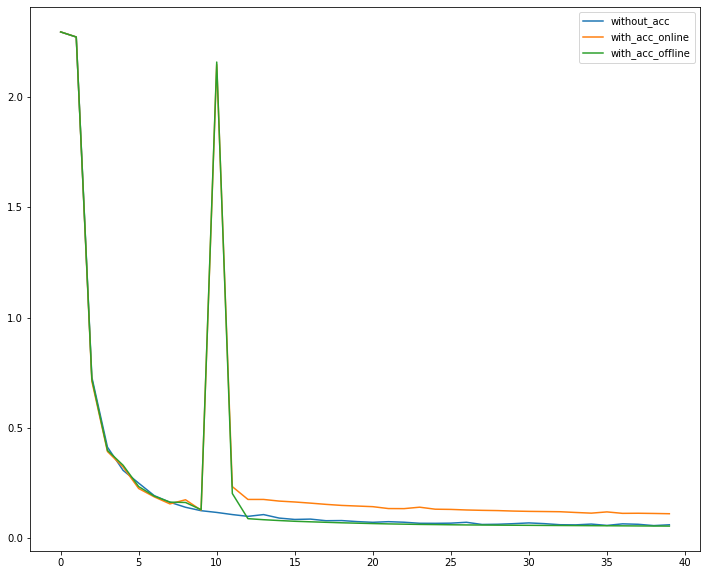

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
x = np.arange(40)
for name, res in results.items():
    plt.plot(x, res["val_loss"], label=name)
plt.legend()

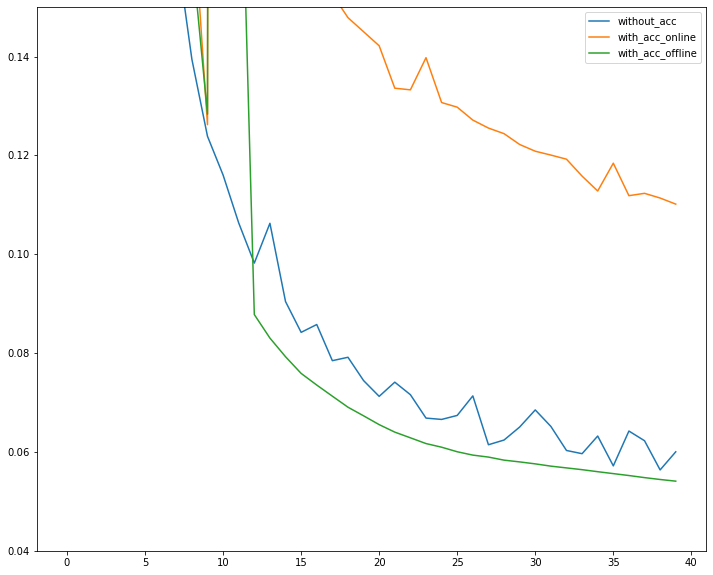

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
x = np.arange(40)
for name, res in results.items():
    plt.plot(x, res["val_loss"], label=name)
plt.ylim(0.04, 0.15)
plt.legend()